<a href="https://colab.research.google.com/github/ali3brt/20-Newsgroups-Dataset/blob/main/04_GANs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction to generative adversarial networks

**Getting the CelebA data**

# Warning: Run only if you dont have anything else to use colab or kaggle for, training gans is computationally expensive.

In [ ]:
!mkdir celeba_gan
!gdown --id 1O7m1010EJjLE5QxLZiM9Fpjs7Oj6e684 -O celeba_gan/data.zip
!unzip -qq celeba_gan/data.zip -d celeba_gan

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1O7m1010EJjLE5QxLZiM9Fpjs7Oj6e684
From (redirected): https://drive.google.com/uc?id=1O7m1010EJjLE5QxLZiM9Fpjs7Oj6e684&confirm=t&uuid=7927f83d-db18-4641-91f3-0e96d68a1d53
To: /content/celeba_gan/data.zip
100% 1.44G/1.44G [00:37<00:00, 38.5MB/s]


**Creating a dataset from a directory of images**

In [ ]:
from tensorflow import keras
dataset = keras.utils.image_dataset_from_directory(
    "celeba_gan",
    label_mode=None,
    image_size=(64, 64),
    batch_size=32,
   )

Found 202599 files.


**Rescaling the images**

In [ ]:
dataset = dataset.map(lambda x: x / 255.)

**Displaying the first image**

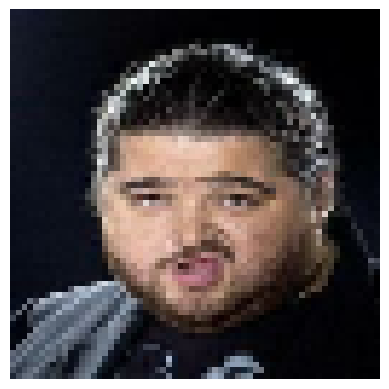

In [ ]:
import matplotlib.pyplot as plt
for x in dataset:
    plt.axis("off")
    plt.imshow((x.numpy() * 255).astype("int32")[0])
    break

### The discriminator

**The GAN discriminator network**

In [ ]:
from tensorflow.keras import layers

discriminator = keras.Sequential(
    [
        keras.Input(shape=(64, 64, 3)),
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [ ]:
discriminator.summary()

Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 32, 32, 64)          │           3,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 16, 16, 128)         │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 8, 8, 128)           │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │           8,193 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 404,801 (1.54 MB)

 Trainable params: 404,801 (1.54 MB)

 Non-trainable params: 0 (0.00 B)

### The generator

**GAN generator network**

In [ ]:
latent_dim = 128

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(8 * 8 * 128),
        layers.Reshape((8, 8, 128)),
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
    ],
    name="generator",
)

In [ ]:
generator.summary()

### The adversarial network

**The GAN `Model`**

In [ ]:
import tensorflow as tf
from tensorflow import keras

class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        """
        Initialize the GAN model with a discriminator, generator, and latent dimension.
        """
        super().__init__()
        self.discriminator = discriminator      # Set the discriminator model
        self.generator = generator              # Set the generator model
        self.latent_dim = latent_dim            # Set the dimensionality of the latent space for generator input
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")  # Metric to track discriminator loss
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")  # Metric to track generator loss

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        """
        Compile the GAN with optimizers and a loss function for both the discriminator and generator.
        """
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer          # Optimizer for the discriminator
        self.g_optimizer = g_optimizer          # Optimizer for the generator
        self.loss_fn = loss_fn                  # Loss function for both the generator and discriminator

    @property
    def metrics(self):
        """
        Returns the metrics to be tracked, used to display the loss metrics in training logs.
        """
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        """
        Perform a single training step, which includes training both the discriminator and generator.
        """
        batch_size = tf.shape(real_images)[0]   # Get the batch size from real images

        # Step 1: Generate random latent vectors for generator input
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Step 2: Use the generator to create fake images
        generated_images = self.generator(random_latent_vectors)

        # Step 3: Combine fake and real images to feed into the discriminator
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Step 4: Create labels for the combined images (1 for fake, 0 for real)
        labels = tf.concat([tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0)

        # Add noise to the labels to make training more stable
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Step 5: Train the discriminator on the combined images
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)   # Get predictions from discriminator
            d_loss = self.loss_fn(labels, predictions)          # Calculate discriminator loss
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)  # Compute gradients
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))  # Apply gradients

        # Step 6: Generate new random latent vectors for generator training
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Step 7: Create misleading labels (0s instead of 1s) to trick the discriminator
        misleading_labels = tf.zeros((batch_size, 1))

        # Step 8: Train the generator via the discriminator's response to its output
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))  # Discriminator prediction on generated images
            g_loss = self.loss_fn(misleading_labels, predictions)                    # Calculate generator loss
        grads = tape.gradient(g_loss, self.generator.trainable_weights)  # Compute gradients
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))  # Apply gradients

        # Update the tracked metrics with current losses
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)

        # Return the current loss values for both discriminator and generator
        return {"d_loss": self.d_loss_metric.result(), "g_loss": self.g_loss_metric.result()}


**A callback that samples generated images during training**

In [ ]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = keras.utils.array_to_img(generated_images[i])
            img.save(f"generated_img_{epoch:03d}_{i}.png")

**Compiling and training the GAN**

In [ ]:
epochs = 5

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)]
)

Epoch 1/5
6332/6332 ━━━━━━━━━━━━━━━━━━━━ 1710s 269ms/step - d_loss: 0.6486 - g_loss: 1.1447
Epoch 2/5
6332/6332 ━━━━━━━━━━━━━━━━━━━━ 1695s 268ms/step - d_loss: 0.6395 - g_loss: 1.0711
Epoch 3/5
6332/6332 ━━━━━━━━━━━━━━━━━━━━ 1699s 267ms/step - d_loss: 0.6199 - g_loss: 1.1490
Epoch 4/5
6332/6332 ━━━━━━━━━━━━━━━━━━━━ 1693s 267ms/step - d_loss: 0.6346 - g_loss: 1.0988
Epoch 5/5
3670/6332 ━━━━━━━━━━━━━━━━━━━━ 11:52 268ms/step - d_loss: 0.6304 - g_loss: 1.0708

In [ ]:
# Save entire generator and discriminator models
generator.save('generator_model.keras')
discriminator.save('discriminator_model.keras')

### Wrapping up

## Summary